In [1]:
%pip install lightgbm

In [3]:
# essentials
import numpy as np 
import pandas as pd 

In [4]:
# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.dpi'] = 100
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
%matplotlib inline

In [5]:
# ml
from sklearn.metrics import accuracy_score, recall_score, ConfusionMatrixDisplay, classification_report, auc, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import joblib

In [27]:
def print_col_type(df):
    non_num_df = df.select_dtypes(include=['object'])
    num_df = df.select_dtypes(exclude=['object'])
    '''separates non-numeric and numeric columns'''
    print("Object columns:")
    for col in non_num_df:
        print(f"{col}")
    print("")
    print("Numeric columns:")
    for col in num_df:
        print(f"{col}")

def missing_cols(df):
    '''prints out columns with its amount of missing values with its %'''
    total = 0
    for col in df.columns:
        missing_vals = df[col].isnull().sum()
        pct = df[col].isna().mean() * 100
        total += missing_vals
        if missing_vals != 0:
          print('{} => {} [{}%]'.format(col, df[col].isnull().sum(), round(pct, 2)))
    
    if total == 0:
        print("no missing values")

In [8]:
from google.colab import files
uploaded = files.upload()

Saving region_A_test.csv to region_A_test.csv
Saving region_B_test.csv to region_B_test.csv
Saving region_C_test.csv to region_C_test.csv
Saving region_D_test.csv to region_D_test.csv
Saving region_E_test.csv to region_E_test.csv


In [9]:
from google.colab import files
uploaded = files.upload()

Saving region_A_train.csv to region_A_train.csv
Saving region_B_train.csv to region_B_train.csv
Saving region_C_train.csv to region_C_train.csv
Saving region_D_train.csv to region_D_train.csv
Saving region_E_train.csv to region_E_train.csv
Saving solution_format.csv to solution_format.csv
Saving solution_train.csv to solution_train.csv


In [12]:
train_a = pd.read_csv("region_A_train.csv")
train_b = pd.read_csv("region_B_train.csv")
train_c = pd.read_csv("region_C_train.csv")
train_d = pd.read_csv("region_C_train.csv")
train_e = pd.read_csv("region_E_train.csv")

test_a = pd.read_csv("region_A_test.csv")
test_b = pd.read_csv("region_B_test.csv")
test_c = pd.read_csv("region_C_test.csv")
test_d = pd.read_csv("region_D_test.csv")
test_e = pd.read_csv("region_E_test.csv")

labels_df = pd.read_csv("solution_train.csv")

In [13]:
train_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     566 non-null    object 
 1   avg.temp                 566 non-null    float64
 2   max.temp                 566 non-null    float64
 3   min.temp                 566 non-null    float64
 4   precipitation            566 non-null    float64
 5   avg.wind.speed           566 non-null    float64
 6   max.wind.speed           566 non-null    float64
 7   max.wind.speed.dir       566 non-null    object 
 8   max.inst.wind.speed      566 non-null    float64
 9   max.inst.wind.speed.dir  566 non-null    object 
 10  min.atmos.pressure       566 non-null    float64
dtypes: float64(8), object(3)
memory usage: 48.8+ KB


In [14]:
train_all = pd.concat([train_a ,train_b ,train_c ,train_d ,train_e], keys=["A", "B", "C", "D", "E"])
train_all

date  avg.temp  max.temp  min.temp  precipitation  avg.wind.speed  \
A 0    229b70a3       3.3      10.2      -2.4            0.0             2.9   
  1    3134f4ff       5.7      13.7      -2.9            0.0             3.6   
  2    dbfaf910      13.8      20.0       9.0            0.0             5.3   
  3    3aea0cf0      11.4      19.3       5.8            0.0             4.2   
  4    f0227f56       2.4       7.7       0.3           43.5             0.9   
...         ...       ...       ...       ...            ...             ...   
E 561  91b2797d       6.3      13.1       0.3            0.0             0.6   
  562  b807fd87       6.2      13.5       0.3            0.0             0.8   
  563  8e0a48e0       9.0      15.9       2.4            0.0             0.6   
  564  9df85983       5.3      13.9       0.1            0.0             1.0   
  565  c9d4fe7c       6.4      15.3      -0.2            0.0             0.7   

       max.wind.speed max.wind.speed.dir  max.inst.wind.speed  \
A 0               9.3                  W                 14.3   
  1              10.7                  W                 15.8   
  2               9.4                 SW                 15.2   
  3              10.1                 SW                 20.6   
  4               3.7                 SW                  5.7   
...               ...                ...                  ...   
E 561             2.2                  S                  4.3   
  562             2.3                 SW                  6.3   
  563             2.4                 NW                  5.7   
  564             3.0                  S                  6.9   
  565             2.1                 NW                  5.5   

      max.inst.wind.speed.dir  min.atmos.pressure  
A 0                         W              1015.1  
  1                         W              1011.3  
  2                         W              1004.2  
  3                        SW              1001.7  
  4                        SW              1003.5  
...                       ...                 ...  
E 561                       S                 NaN  
  562                       W                 NaN  
  563                       W                 NaN  
  564                      NW                 NaN  
  565                       N                 NaN  

[2830 rows x 11 columns]

In [15]:
train_all_lvls = train_all.reset_index()
train_all_lvls.rename(columns = {"level_0": "region"}, inplace=True)
train_all_lvls.drop(columns=['level_1'], inplace=True)
train_all_lvls.head()

,region,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir,min.atmos.pressure
0,A,229b70a3,3.3,10.2,-2.4,0.0,2.9,9.3,W,14.3,W,1015.1
1,A,3134f4ff,5.7,13.7,-2.9,0.0,3.6,10.7,W,15.8,W,1011.3
2,A,dbfaf910,13.8,20.0,9.0,0.0,5.3,9.4,SW,15.2,W,1004.2
3,A,3aea0cf0,11.4,19.3,5.8,0.0,4.2,10.1,SW,20.6,SW,1001.7
4,A,f0227f56,2.4,7.7,0.3,43.5,0.9,3.7,SW,5.7,SW,1003.5


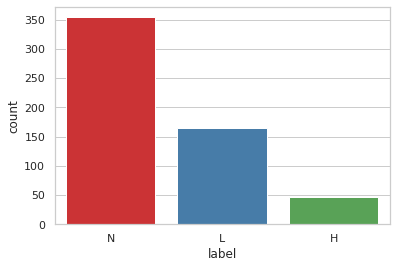

In [16]:
sns.countplot(x = 'label', data = labels_df, palette="Set1");

In [17]:
train_all_lvls.columns[2:]

Index(['avg.temp', 'max.temp', 'min.temp', 'precipitation', 'avg.wind.speed',
       'max.wind.speed', 'max.wind.speed.dir', 'max.inst.wind.speed',
       'max.inst.wind.speed.dir', 'min.atmos.pressure'],
      dtype='object')

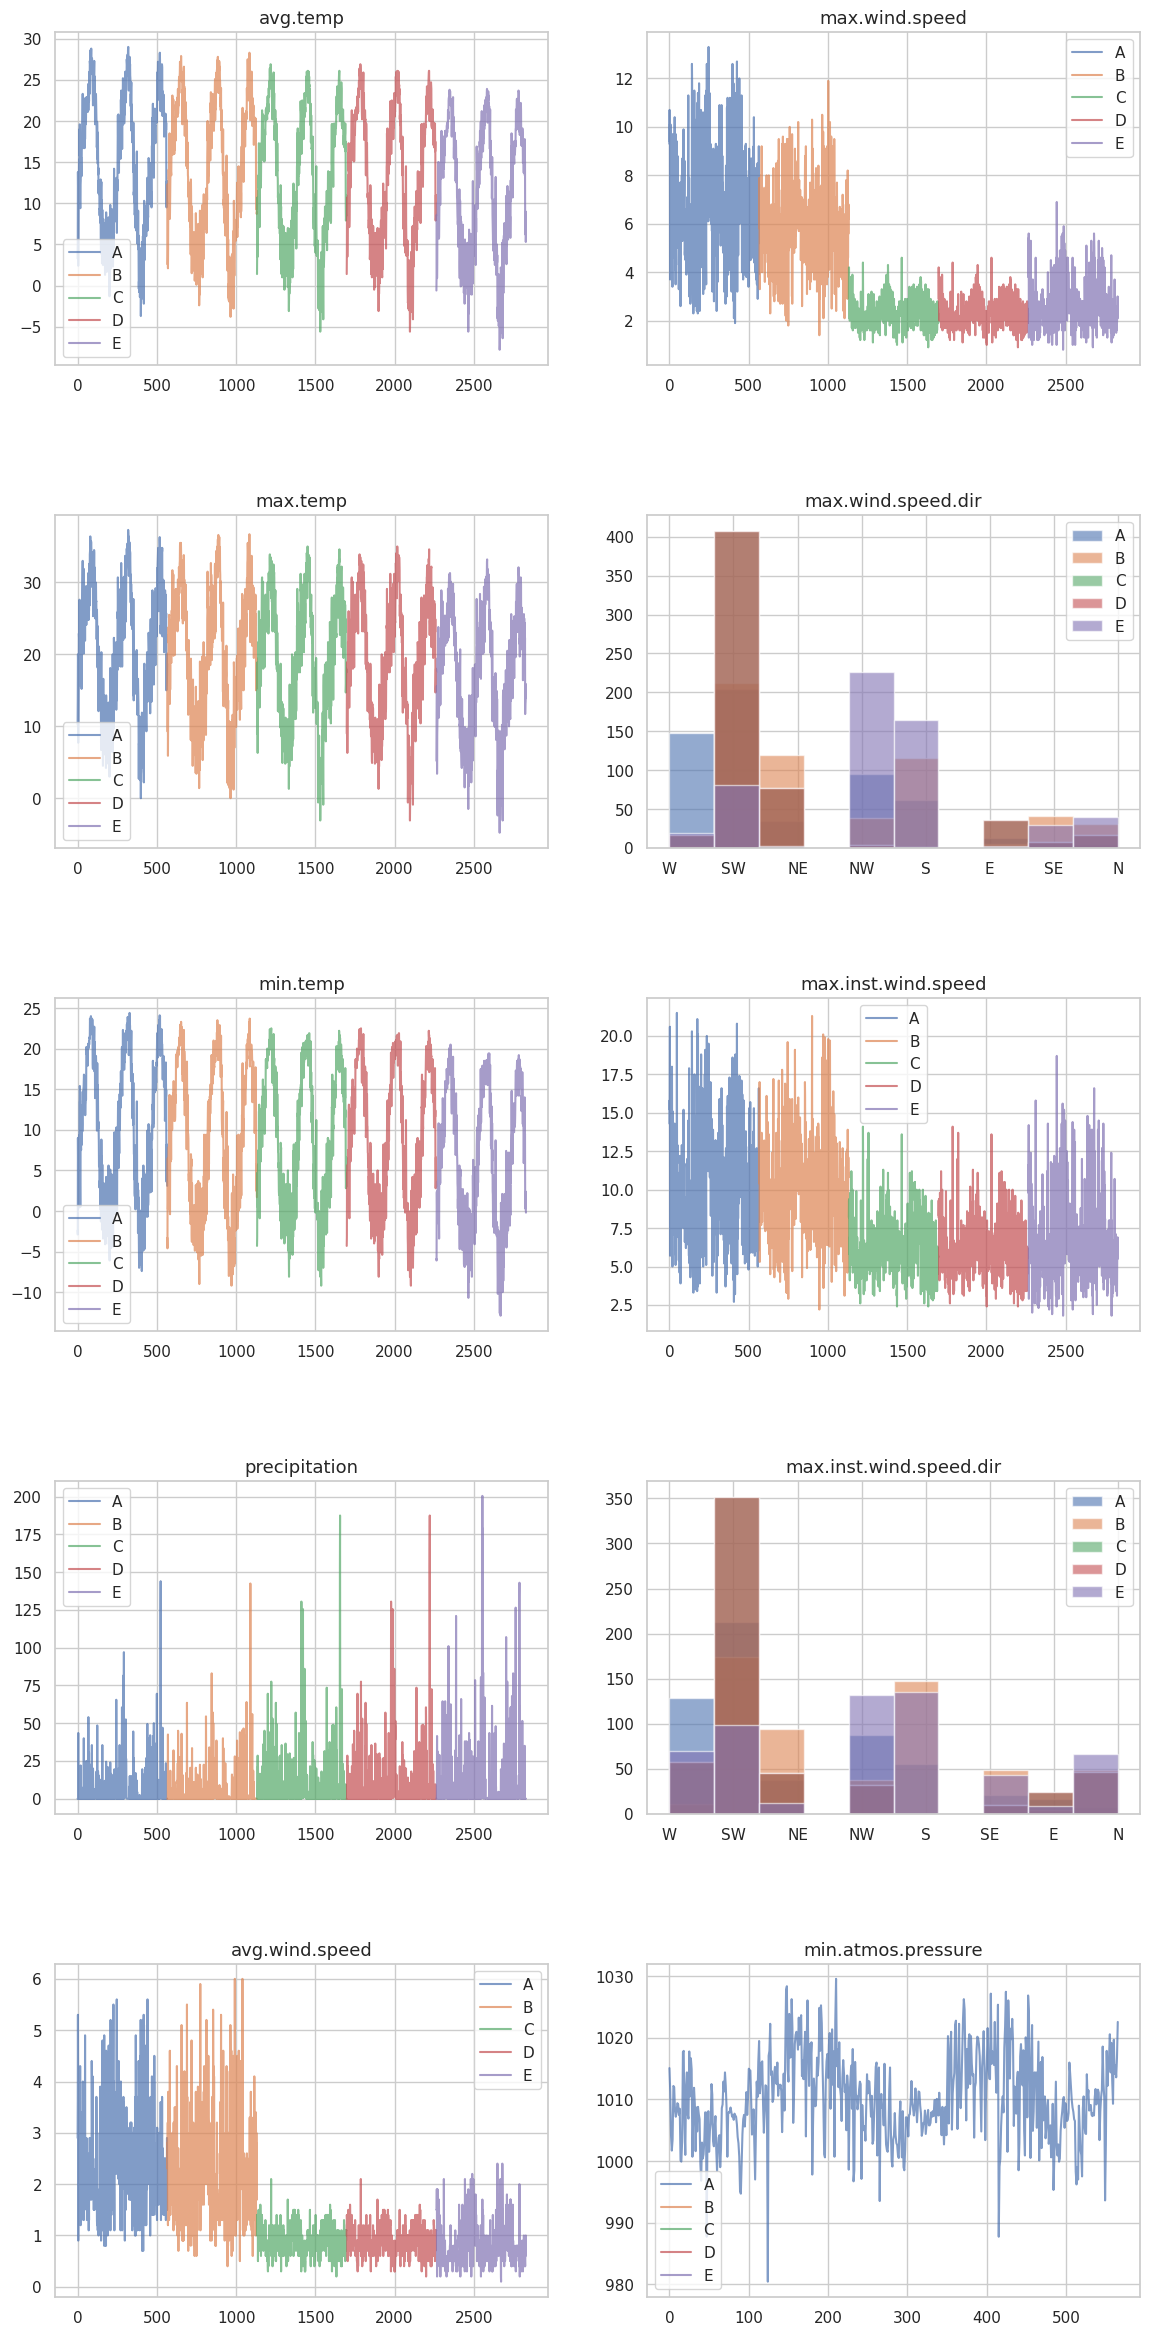

In [18]:
fig, axes = plt.subplots(5,2,figsize=(14, 30), dpi=100)

for i, col_name in enumerate(train_all_lvls.columns[2:]):
    if train_all_lvls[col_name].dtype == 'O':
        train_all_lvls.groupby('region')[col_name].hist(ax=axes[i%5][i//5], alpha=0.6);
        axes[i%5][i//5].legend(["A", "B", "C", "D", "E"]);
    else:
        train_all_lvls.groupby('region')[col_name].plot(ax=axes[i%5][i//5], alpha=0.7);
        axes[i%5][i//5].legend();
    axes[i%5][i//5].set_title(f'{col_name}', fontsize=13);
    plt.subplots_adjust(hspace=0.45)

In [28]:
missing_cols(train_all_lvls)

min.atmos.pressure => 2264 [80.0%]


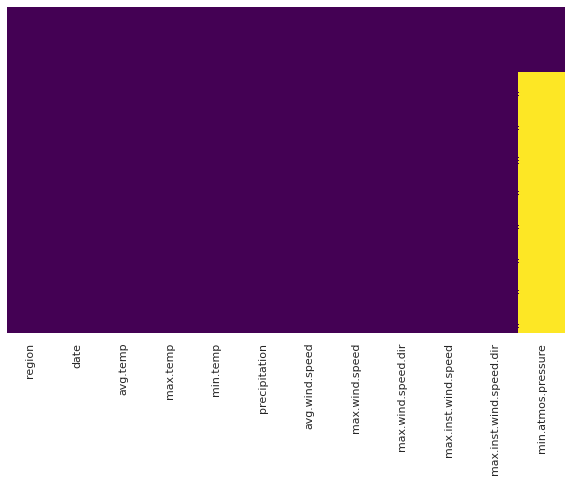

In [29]:
plt.figure(figsize=(10, 6))
sns.heatmap(train_all_lvls.isnull(), yticklabels=False, cmap='viridis', cbar=False);

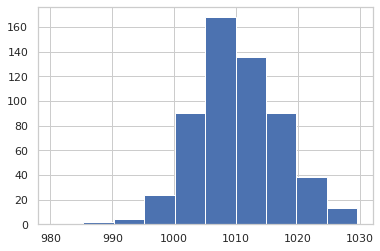

In [30]:
train_all_lvls['min.atmos.pressure'].hist();

In [31]:
mean_atmos = train_all_lvls['min.atmos.pressure'].mean()
train_all_lvls.fillna(mean_atmos, inplace=True)

In [32]:
missing_cols(train_all_lvls)

no missing values


In [34]:
test_all = pd.concat([test_a ,test_b ,test_c ,test_d ,test_e], keys=["A", "B", "C", "D", "E"])
test_all

date  avg.temp  max.temp  min.temp  precipitation  avg.wind.speed  \
A 0    b92d713a       5.0      11.9       0.7            0.0             3.6   
  1    18817005       2.9       9.1      -1.8            0.0             3.4   
  2    8e19dc3c       9.8      18.9       0.4            0.0             3.1   
  3    6f0929dc      13.4      21.2       6.1            0.0             3.4   
  4    c7506622       9.1      16.3       2.4            0.0             2.7   
...         ...       ...       ...       ...            ...             ...   
E 373  01a1b150       6.9       9.5       4.3            1.5             0.3   
  374  90b49549       6.5      15.8      -0.1            0.0             0.6   
  375  15bc4979       7.9      10.3       3.5            9.5             0.3   
  376  b4104846       9.1      17.1       4.9           11.0             0.6   
  377  28c40b9c       7.0      17.1       0.6            0.0             0.8   

       max.wind.speed max.wind.speed.dir  max.inst.wind.speed  \
A 0              11.9                 NW                 16.7   
  1               9.6                 SW                 15.4   
  2               8.9                  W                 13.6   
  3               8.8                 SW                 13.8   
  4               7.6                 NW                 11.9   
...               ...                ...                  ...   
E 373             1.2                  S                  2.7   
  374             2.2                 SE                  4.7   
  375             1.7                 SW                  5.8   
  376             2.1                 SW                  5.8   
  377             2.8                  S                  5.2   

      max.inst.wind.speed.dir  min.atmos.pressure  
A 0                        NW              1009.2  
  1                        SW              1013.6  
  2                         W              1002.6  
  3                        SW              1003.1  
  4                        NW              1011.9  
...                       ...                 ...  
E 373                      SE                 NaN  
  374                       S                 NaN  
  375                       S                 NaN  
  376                      NW                 NaN  
  377                       S                 NaN  

[1890 rows x 11 columns]

In [36]:
test_all = pd.concat([train_a ,train_b ,train_c ,train_d ,train_e], keys=["A", "B", "C", "D", "E"])
test_all_lvls = test_all.reset_index()
test_all_lvls.rename(columns = {"level_0": "region"}, inplace=True)
test_all_lvls.drop(columns=['level_1'], inplace=True)
test_all_lvls.head()

,region,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir,min.atmos.pressure
0,A,229b70a3,3.3,10.2,-2.4,0.0,2.9,9.3,W,14.3,W,1015.1
1,A,3134f4ff,5.7,13.7,-2.9,0.0,3.6,10.7,W,15.8,W,1011.3
2,A,dbfaf910,13.8,20.0,9.0,0.0,5.3,9.4,SW,15.2,W,1004.2
3,A,3aea0cf0,11.4,19.3,5.8,0.0,4.2,10.1,SW,20.6,SW,1001.7
4,A,f0227f56,2.4,7.7,0.3,43.5,0.9,3.7,SW,5.7,SW,1003.5


In [37]:
missing_cols(test_all_lvls)

min.atmos.pressure => 2264 [80.0%]
